# ANÁLISE EXPLORATORIA DOS DADOS CASE HOSPITAIS

In [2]:
# Efetua limpeza do ambiente
import gc
import os


gc.collect()

0

In [ ]:
# 2. Instala as libs necessarias
import subprocess
import sys

# Lista de libs
libs = [
    "pandas", "numpy", "scipy", "xgboost",
    "matplotlib", "seaborn", "statsmodels", "openpyxl", "xlrd",
    "geopandas", "requests", "tqdm", "geopy"
]

# Função para instalar pacotes
def install(lib):
    subprocess.check_call([sys.executable, "-m", "pip", "install", lib])

# Instalar pacotes
for lib in libs:
    try:
        __import__(lib)
    except ImportError:
        install(lib)

# Importar pacotes
import pandas as pd
import numpy as np
import scipy
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import openpyxl
import geopandas as gpd
import requests
import json
from tqdm import tqdm
from scipy.stats import ttest_ind, pearsonr

In [13]:
# 3. Carrega os dados para transformação e análise

# Define o caminho do arquivo com os dados
file_path = "C:/Users/super/Downloads/case_hospital/db_aed_case_hospital.xlsx"

# Lista as planilhas disponíveis no arquivo
sheet_names = pd.ExcelFile(file_path).sheet_names

# Importa apenas a planilha necessaria, nesse caso a primeira
df_alt1 = pd.read_excel(file_path, sheet_name=sheet_names[0])

In [14]:
# 4. Função para padronizar colunas
def transformar_maiusculas(df, coluna):
    # Verifica se a coluna existe no df
    if coluna not in df.columns:
        raise ValueError("A coluna não existe no df.")
    
    # Transforma o nome da coluna padronizando para letras maiusculas
    df[coluna] = df[coluna].str.upper()
    
    return df

# Exemplo de uso da função acim
#df_alt1 = transformar_maiusculas(df_alt1, 'nome_da_coluna')

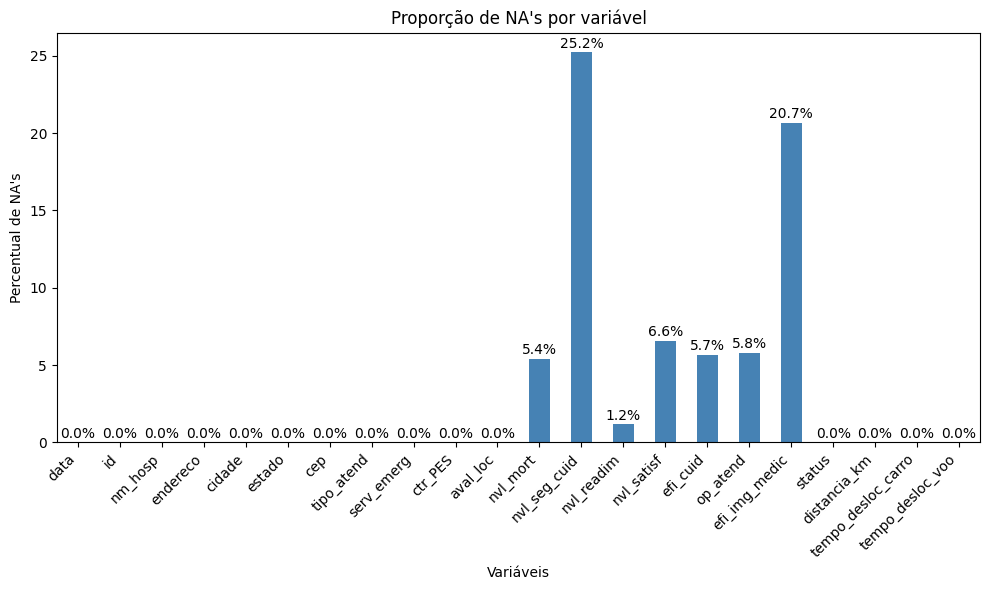

In [ ]:
# Análise da proporção de dados ausentes

# Calcula a proporção de NA por variável no dataset
prop_missing = df_alt1.isna().mean() * 100
prop_missing = prop_missing.drop('resultado_geral', errors='ignore')

# Gera gráfico de barras contendo a proporção de NAs
plt.figure(figsize=(10, 6))
prop_missing.plot(kind='bar', color='steelblue')
plt.xlabel('Variáveis')
plt.ylabel('Percentual de NA\'s')
plt.title('Proporção de NA\'s por variável')

# Insere rótulos nos valores percentuais
for index, value in enumerate(prop_missing):
    plt.text(index, value + 0.1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Após calcular a proporção de NA's podemos ter uma investigação mais
afundo sobre. Os valores faltantes se concetram na variaveis sobre
resultados sobre indicadores hospitalares os maiores percentuais de
dados faltantes ficaram com as variaveis de segurança de informaçao
hospitalar com 25,2% dos dados. Seguido pela variavel de indicador de
eficiencia do uso da imagem médica com 20,7%. Ambos com percentuais
relativamente elevados. As demais variaveis com dados faltantes são
todas sobre indicadores hospitalares com valores na faixa de 5 a 6%. A
variavel que demonstrou menor proporção de faltantes foi a variavel do
indicador de readmissão hospitalar com 1,2%, felizmente sendo uma
variavel de suma importancia na avaliacao e com poucas lacunas de
informacoes.

A proporçao de dados faltantes no indicadores é alarmante, o que pode
ocasionar de certa forma uma perda de informacoes que possam ser de
grande valia em outras analises. Porem, optou-se nessa situação alheio
de mais informações de se remover as variaveis NA's dado o carater
qualitativo de como as avaliacoes dos indicadores foi inicialmente
disposto. Se por ventura fossem notas de variaveis numericas continuas
poderiamos preenche-las com a media dos dados, porem nao é o caso.

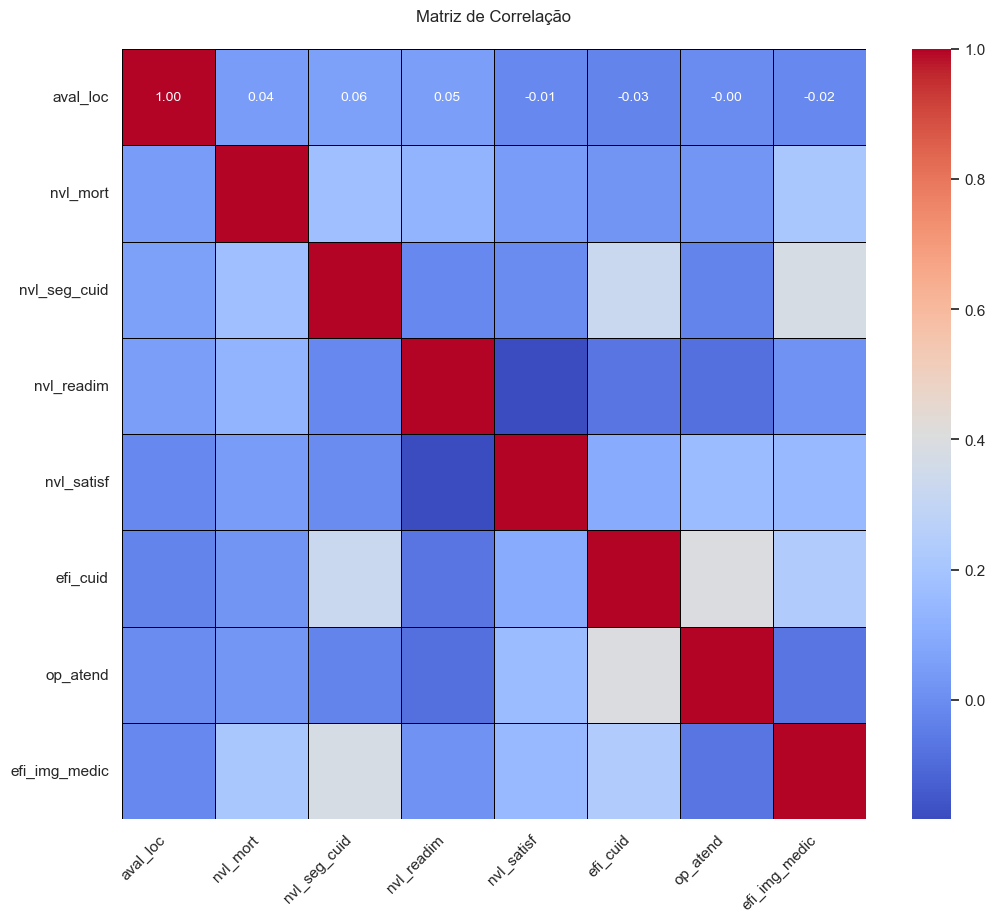

In [ ]:
# Análise de Correlação
# Filtra apenas variáveis de interesse, substituindo valores ausentes por 0
selected_columns = df_alt1.loc[:, 'aval_loc':'efi_img_medic'].fillna(0)

# Calcula a matriz de correlação
correlation_matrix = selected_columns.corr()

# Plota p gráfico com a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            cbar=True, annot_kws={"size": 10}, linewidths=.5, linecolor='black')
plt.title('Matriz de Correlação', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Resultado da análise de correlação do escores de uso hospitalar e avaliação local geral

## 1. Satisfação dos Pacientes:

A variável nvl_satisf tem uma correlação positiva moderada com op_atend
(0.25), sugerindo que a satisfação dos pacientes está moderadamente
associada à opinião sobre o atendimento recebido. Uma correlação
positiva também existe entre nvl_satisf e efi_cuid (0.11), indicando que
a eficiência dos cuidados também contribui para a satisfação dos
pacientes.

## 2. Readmissão e Satisfação:

nvl_readim tem uma correlação negativa fraca com nvl_satisf (-0.29),
indicando que maiores taxas de readmissão estão associadas ligeramente a
uma pior experiência dos pacientes.

## 3. Avaliação Local e Imagem Médica:

A variável aval_loc tem uma correlação negativa com efi_img_medic
(-0.14), sugerindo que uma avaliação local mais alta pode estar
associada a uma imagem médica menos eficiente. Porém, vemos que a
magnitude da relação é de certa forma fraca.

## 4. Segurança dos Cuidados:

A variável nvl_seg_cuid mostra uma correlação positiva com efi_cuid
(0.06), indicando que uma melhor segurança nos cuidados está associada a
uma maior eficiência nos cuidados, Embora a correlação seja muito fraca.

## 5. Uso Eficiente da Imagem Médica:

op_atend tem uma correlação negativa com efi_img_medic (-0.22),
sugerindo que uma melhor opinião sobre o atendimento pode estar
associada a uma eficiência menor na imagem médica.


# Pontos de maior interesse para análise

### a) Fatores Positivos para Satisfação:

Eficiência dos cuidados e opinião sobre o atendimento são fatores
positivos para a satisfação dos pacientes.

### b) Fatores Negativos para Satisfação:

Altas taxas de readmissão e baixa eficiência na imagem médica estão
negativamente associadas à satisfação dos pacientes.

### c) Segurança e Eficiência:

Segurança nos cuidados é crucial para a eficiência geral dos cuidados
prestados.

In [ ]:
# Analisando a correlação entre a avaliação local e o resultado geral
df_alt1['cidade'] = df_alt1['cidade'].str.upper()
df_alt1['estado'] = df_alt1['estado'].str.upper()

# Calcula o valor médio da avaliação local por estado
media_avaliacoes = df_alt1.groupby('estado')['aval_loc'].mean().reset_index()

# Calcula o valor médio do resultado_geral por estado
media_resultado_geral = df_alt1.groupby('estado')['resultado_geral'].mean().reset_index()

# Merge entre os resultados
medias = pd.merge(media_avaliacoes, media_resultado_geral, on='estado')

# Reshape os dados para formato longo
medias_melted = medias.melt(id_vars='estado', var_name='metric', value_name='value')

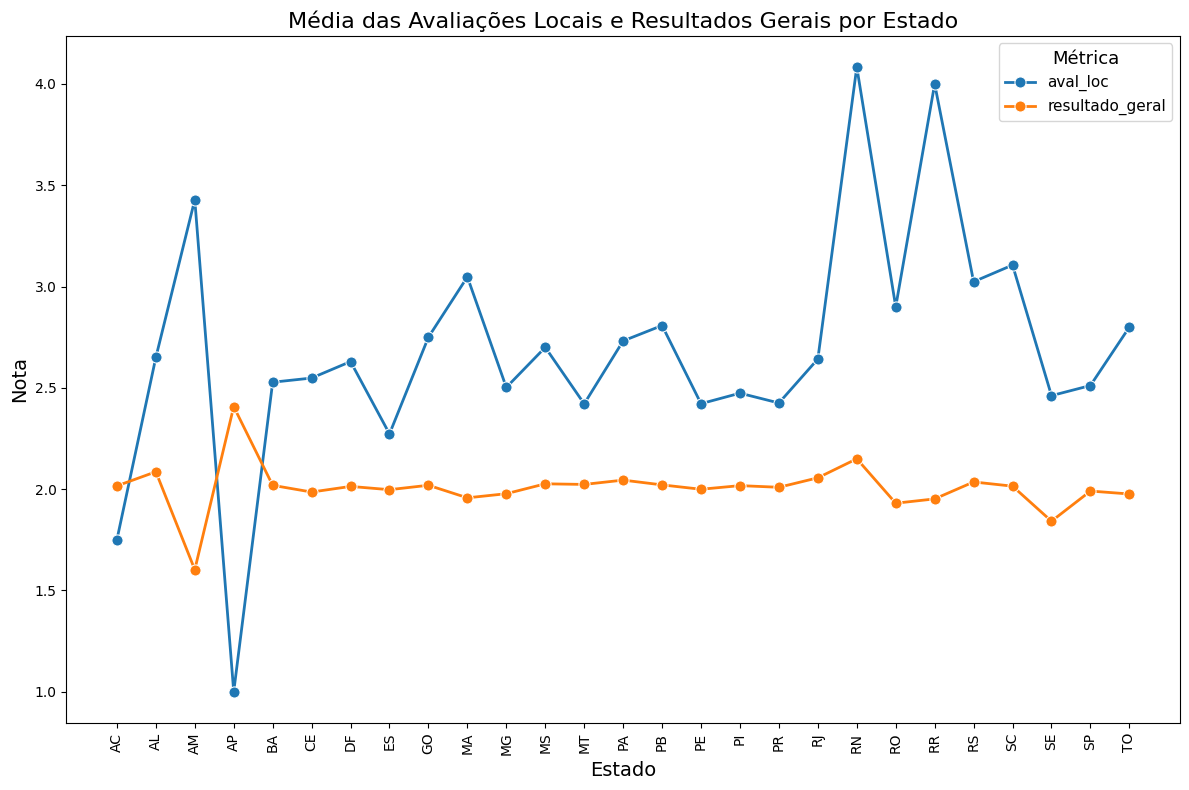

In [33]:
# Gráfico comparativo entre as médias
plt.figure(figsize=(12, 8))
sns.lineplot(data=medias_melted, x='estado', y='value', hue='metric', marker='o', linewidth=2, markersize=8)

# Ajusta os rótulos e o título do gráfico
plt.title('Média das Avaliações Locais e Resultados Gerais por Estado', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Nota', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Métrica', title_fontsize='13', fontsize='11')

# Plotando o gráfico de médias
plt.tight_layout()
plt.show()

No gráfico acima podemos ver que há uma grande variabilidade no
intervalo de 2 a 4 de notas da avaliação local. No caso do
resultado_geral, temos uma constância maior nos valores observados,
demonstrando menor variabilidade dos dados.

In [34]:
# Média da avaliação local por tipo de atendimento
# Calcula o valor médio para aval_loc por tipo_atend
media_aval_loc_por_tipo_atend = df_alt1.groupby('tipo_atend')['aval_loc'].mean().reset_index()
media_aval_loc_por_tipo_atend.columns = ['tipo_atend', 'media_aval_loc']

# Separa o data set em dois tipos de hospitais possiveis
group1 = df_alt1[df_alt1['tipo_atend'] != "hospitais de acesso crítico"]['aval_loc'].dropna()
group2 = df_alt1[df_alt1['tipo_atend'] == "hospitais de acesso crítico"]['aval_loc'].dropna()

# Executa o teste t Student
t_stat, p_value = ttest_ind(group1, group2, equal_var=True)

# Exibe o resultado
print(f"T-statistic: {t_stat}, p-value: {p_value}")

T-statistic: 2.0157387628534065, p-value: 0.04399172854978625


Brevemente analisando as duas médias para avaliação local, por meio do teste de hipótese t-student
foi possível denotar que partindo das médias de 2,64 para hospitais de cuidados agudos e 2,41 de média para
hospitais de acesso crítico, há diferença estatisticamente significante. Portando a média superior de hospitais de cuidados agudos
pode enfatizar uma relação melhor entre o hospital e seus pacientes. Porém é aconselhável avaliar esse cenário com outras variáveis para determinar se o compartamento se repete.

Correlacao de Pearson: -0.4415462390004893


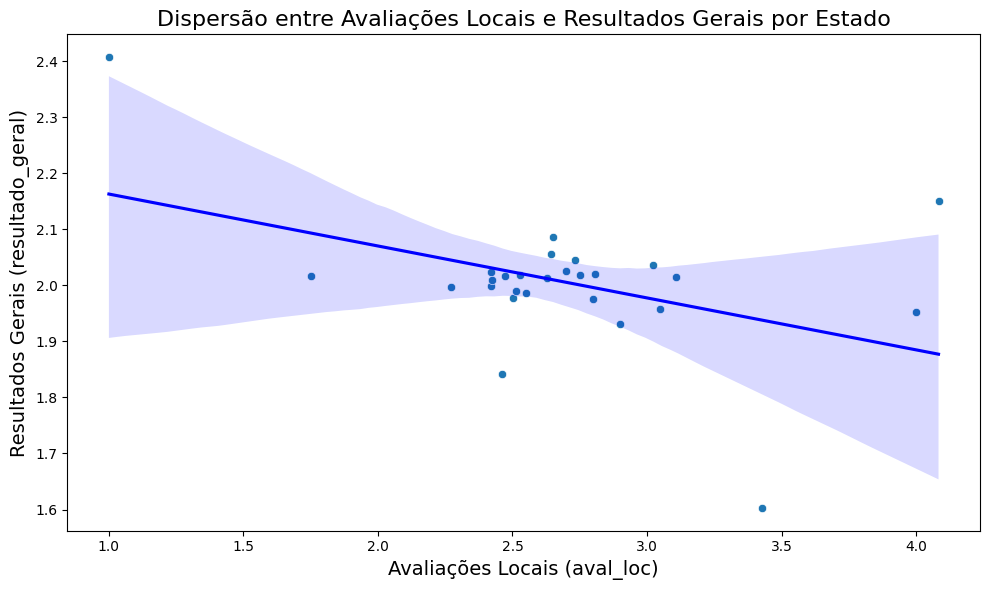

In [35]:
# Gráfico de dispersão entre a Avaliação Local e Resultado Geral
# Calcula a correlação de Pearson das duas variáveis
correlacao, _ = pearsonr(medias['aval_loc'], medias['resultado_geral'])
print(f'Correlacao de Pearson: {correlacao}')

# Gera gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='aval_loc', y='resultado_geral', data=medias)
sns.regplot(x='aval_loc', y='resultado_geral', data=medias, scatter=False, color='blue')

# Ajustando rótulos e o título do gráfico
plt.title('Dispersão entre Avaliações Locais e Resultados Gerais por Estado', fontsize=16)
plt.xlabel('Avaliações Locais (aval_loc)', fontsize=14)
plt.ylabel('Resultados Gerais (resultado_geral)', fontsize=14)

# Exibe o gráfico
plt.tight_layout()
plt.show()

Com o valor de correlação obtido de -0,44 temos uma indicação de
correlação negativa de grau moderado entre ambas as variáveis. De outro
modo, podemos atribuir uma possível relação de estados com melhores
médias da avaliação local tendem a ter resultados piores na média de
resultados gerais.

Fato esse que corrobora com a hipótese já levantada, de que as
avaliações locais são genéricas e refletem pouco da realidade e
qualidade dos hospitais avaliados. Há uma grande variabilidade entre os
estados, o que demonstra uma possível falta de padronização e critérios
claros de avaliação para a variavel aval_loc. Diferentemente da variável
resultado_geral que utilizou do mesmo critério para todos os hospitais
independente de localidade utilizando como base informações de
instituições de saúde e profissionais da área, trazendo assim mais
consistência na avaliação.

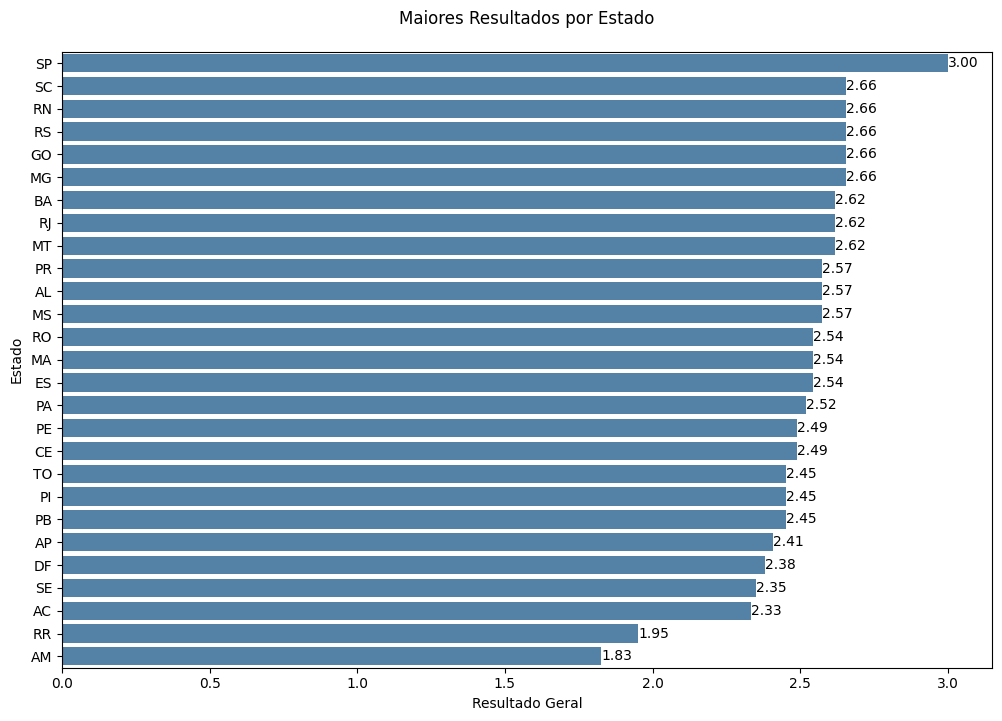

In [37]:
# Rankeamento do Resultado Geral de hospitais por estado

# Agrupa e filtra maior resultado_geral por estado
maiores_resultados = df_alt1.loc[df_alt1.groupby('estado')['resultado_geral'].idxmax()]

# Filtra valores NA em resultado_geral
maiores_resultados = maiores_resultados.dropna(subset=['resultado_geral'])

# Remove duplicações
maiores_resultados = maiores_resultados.drop_duplicates(subset=['estado'])

# Ordena do melhor para o pior
maiores_resultados_sorted = maiores_resultados.sort_values(by='resultado_geral', ascending=False)

# Gera um gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x='resultado_geral', y='estado', data=maiores_resultados_sorted, color='steelblue')

# Adiciona os rótulos de valor 
for index, value in enumerate(maiores_resultados_sorted['resultado_geral']):
    plt.text(value, index, f'{value:.2f}', color='black', ha='left', va='center')

# Plota o gráfico
plt.title('Maiores Resultados por Estado', pad=20)
plt.xlabel('Resultado Geral')
plt.ylabel('Estado')
plt.show()

Nesse gráfico temos o maior resultado individual por hospital para cada
estado. Podemos notar que São Paulo tem o melhor resultado, mas também
temos outros estados com métricas boas, como Góias, Minas Gerais, Rio
Grande do Norte, Rio Grande do Sul, Santa Catarina, Bahia, Mato Grosso e
Alagoas. Creio que com esse apanhado é possível notar futuras
oportunidades de integração com hospitais de qualidade que estejam em
outros estados visando uma maior expansão a nível nacional e também
maior capilaridade dos serviços e alcance da empresa, consequentemente
gerando maior receita e lucro.